# Cluster interpretability

In this notebook, we explore several techniques for extracting patterns from the clusters.
The goal: have an interpretable representation of the relevance of the feature in our profiles/clusters
- For understanding the clusters
- For better profile explanation for the users

A way to do it: consider profiles as documents and the task as NLP.

The first approach is to use TF-IDF. However, they have some limitations as shared values, but with different distribution over the profiles/clusters, have zero weight. This behavior may represent a problem since we have fixed low-cardinality categorical classes, e.g., scheduling class or priority

Another solution is to develop One-vs-all classifiers (white box techniques). This approach:
- Gives us also the opportunity to evaluate the profile attribution/assignment (via classification)
- Clear and algorithmically grounded
- Gives an “interpretation” available for the final user



## Imports

In [161]:
import pandas as pd

import dask.dataframe as dd
from dask.delayed import delayed

import random

import os
from collections import Counter
from collections import defaultdict

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import PercentFormatter

import numpy as np

import math

import seaborn as sns

from gcd_dask_mgmt import extract_delayed_dask_dataframe

## Load data

In [2]:
static_metrics = pd.read_csv('data/static_metrics_and_kmeans.csv')

In [3]:
static_metrics

,job ID,priority,different machines restriction,disk space request - Q1,disk space request - Q2,disk space request - Q3,disk space request - Q4,disk space request - Quartiles,memory request - Q1,memory request - Q2,...,CPU request - Quartiles,priority labels,user,logical job name,scheduling class,K-Means = 2,K-Means = 4,K-Means = 6,K-Means = 8,K-Means = 10
0,3418356,9,0,0,0,0,1,Q4,0,0,...,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,fGRnr2XEPDr3kQsPccU/k1LELeeQonkj6hDpTP7ALkg=,3,0,1,1,1,1
1,3418405,9,0,0,0,0,1,Q4,0,0,...,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,q6nwarTUw/Xct0ONQEdblvVhW8uWTquTp8C5la5YfRE=,3,0,1,1,1,1
2,6724949,9,0,0,0,0,1,Q4,0,0,...,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,4my5Elvc5RumesxoVeuFovkoS28KYA9C3pIBi2bY5Io=,3,0,1,1,1,1
3,28185708,1,0,1,0,0,0,Q1,0,1,...,Q3,"Free [0,1]",WVtO5qw3sNnP4MeiRUnqr07CekrYMU12Mc7GbsgnjhQ=,JGBCBdeRFciFaU6LrbO9Y5w1lBoZ1MyX5Pnx4m05HK8=,2,0,1,1,1,1
4,124371644,9,0,0,0,0,1,Q4,0,0,...,Q3,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,HcYZ4RNZRxmh/W+WuzNBOVk4sOCdDshVEB/McWxfyyk=,3,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64928,6486612269,1,0,0,1,0,0,Q2,0,0,...,Q3,"Free [0,1]",E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=,QZm5VyyEiL9TpVhasvtcMxPxENJqlNX4Fn2LdEe+Ff0=,1,1,0,0,0,0
64929,6486612710,4,0,0,0,0,1,Q4,0,0,...,Q2,"Other [2,8]",HxdST/yDI1TlIkr0Povf9KaXGGG8x4iVXX6o/iSIghM=,YI5372ouHbbTv6b594D2bDWC283uv6QcuE41Mst3BFk=,0,1,3,5,5,4
64930,6486630408,4,0,0,1,0,0,Q2,1,0,...,Q3,"Other [2,8]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,ZoHIMIMjYenKtCPq0iy70XUxyF0JDf1HuW6yUzS4dBM=,0,1,0,0,0,0
64931,6486631154,8,0,0,1,0,0,Q2,0,1,...,Q2,"Other [2,8]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,cLRsAgA+ajg6giausco6dsV5PxWsqEJZDLdHWhd6v0E=,2,1,0,0,0,0


## TF-IDF

In [4]:
for c in static_metrics.columns:
    print(c)

job ID
priority
different machines restriction
disk space request - Q1
disk space request - Q2
disk space request - Q3
disk space request - Q4
disk space request - Quartiles
memory request - Q1
memory request - Q2
memory request - Q3
memory request - Q4
memory request - Quartiles
CPU request - Q1
CPU request - Q2
CPU request - Q3
CPU request - Q4
CPU request - Quartiles
priority labels
user
logical job name
scheduling class
K-Means = 2
K-Means = 4
K-Means = 6
K-Means = 8
K-Means = 10


In [5]:
tfidf_df = static_metrics[['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles', 'priority labels', 'user', 'logical job name', 'scheduling class']]

In [6]:
tfidf_df

,different machines restriction,disk space request - Quartiles,memory request - Quartiles,CPU request - Quartiles,priority labels,user,logical job name,scheduling class
0,0,Q4,Q4,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,fGRnr2XEPDr3kQsPccU/k1LELeeQonkj6hDpTP7ALkg=,3
1,0,Q4,Q4,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,q6nwarTUw/Xct0ONQEdblvVhW8uWTquTp8C5la5YfRE=,3
2,0,Q4,Q4,Q4,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,4my5Elvc5RumesxoVeuFovkoS28KYA9C3pIBi2bY5Io=,3
3,0,Q1,Q2,Q3,"Free [0,1]",WVtO5qw3sNnP4MeiRUnqr07CekrYMU12Mc7GbsgnjhQ=,JGBCBdeRFciFaU6LrbO9Y5w1lBoZ1MyX5Pnx4m05HK8=,2
4,0,Q4,Q4,Q3,Production [9],70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,HcYZ4RNZRxmh/W+WuzNBOVk4sOCdDshVEB/McWxfyyk=,3
...,...,...,...,...,...,...,...,...
64928,0,Q2,Q3,Q3,"Free [0,1]",E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=,QZm5VyyEiL9TpVhasvtcMxPxENJqlNX4Fn2LdEe+Ff0=,1
64929,0,Q4,Q4,Q2,"Other [2,8]",HxdST/yDI1TlIkr0Povf9KaXGGG8x4iVXX6o/iSIghM=,YI5372ouHbbTv6b594D2bDWC283uv6QcuE41Mst3BFk=,0
64930,0,Q2,Q1,Q3,"Other [2,8]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,ZoHIMIMjYenKtCPq0iy70XUxyF0JDf1HuW6yUzS4dBM=,0
64931,0,Q2,Q2,Q2,"Other [2,8]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,cLRsAgA+ajg6giausco6dsV5PxWsqEJZDLdHWhd6v0E=,2


In [7]:
for lab in tfidf_df.columns:
    joined_vals = []
    for v in tfidf_df[lab].values:
        new_v = f"{lab} {v}"
        new_v = '_'.join(new_v.split(' '))
        joined_vals.append(new_v)
    tfidf_df[lab] = joined_vals

/tmp/ipykernel_71109/1789194000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_df[lab] = joined_vals


In [8]:
tfidf_df

,different machines restriction,disk space request - Quartiles,memory request - Quartiles,CPU request - Quartiles,priority labels,user,logical job name,scheduling class
0,different_machines_restriction_0,disk_space_request_-_Quartiles_Q4,memory_request_-_Quartiles_Q4,CPU_request_-_Quartiles_Q4,priority_labels_Production_[9],user_70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,logical_job_name_fGRnr2XEPDr3kQsPccU/k1LELeeQo...,scheduling_class_3
1,different_machines_restriction_0,disk_space_request_-_Quartiles_Q4,memory_request_-_Quartiles_Q4,CPU_request_-_Quartiles_Q4,priority_labels_Production_[9],user_70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,logical_job_name_q6nwarTUw/Xct0ONQEdblvVhW8uWT...,scheduling_class_3
2,different_machines_restriction_0,disk_space_request_-_Quartiles_Q4,memory_request_-_Quartiles_Q4,CPU_request_-_Quartiles_Q4,priority_labels_Production_[9],user_70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,logical_job_name_4my5Elvc5RumesxoVeuFovkoS28KY...,scheduling_class_3
3,different_machines_restriction_0,disk_space_request_-_Quartiles_Q1,memory_request_-_Quartiles_Q2,CPU_request_-_Quartiles_Q3,"priority_labels_Free_[0,1]",user_WVtO5qw3sNnP4MeiRUnqr07CekrYMU12Mc7GbsgnjhQ=,logical_job_name_JGBCBdeRFciFaU6LrbO9Y5w1lBoZ1...,scheduling_class_2
4,different_machines_restriction_0,disk_space_request_-_Quartiles_Q4,memory_request_-_Quartiles_Q4,CPU_request_-_Quartiles_Q3,priority_labels_Production_[9],user_70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,logical_job_name_HcYZ4RNZRxmh/W+WuzNBOVk4sOCdD...,scheduling_class_3
...,...,...,...,...,...,...,...,...
64928,different_machines_restriction_0,disk_space_request_-_Quartiles_Q2,memory_request_-_Quartiles_Q3,CPU_request_-_Quartiles_Q3,"priority_labels_Free_[0,1]",user_E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=,logical_job_name_QZm5VyyEiL9TpVhasvtcMxPxENJql...,scheduling_class_1
64929,different_machines_restriction_0,disk_space_request_-_Quartiles_Q4,memory_request_-_Quartiles_Q4,CPU_request_-_Quartiles_Q2,"priority_labels_Other_[2,8]",user_HxdST/yDI1TlIkr0Povf9KaXGGG8x4iVXX6o/iSIghM=,logical_job_name_YI5372ouHbbTv6b594D2bDWC283uv...,scheduling_class_0
64930,different_machines_restriction_0,disk_space_request_-_Quartiles_Q2,memory_request_-_Quartiles_Q1,CPU_request_-_Quartiles_Q3,"priority_labels_Other_[2,8]",user_fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,logical_job_name_ZoHIMIMjYenKtCPq0iy70XUxyF0JD...,scheduling_class_0
64931,different_machines_restriction_0,disk_space_request_-_Quartiles_Q2,memory_request_-_Quartiles_Q2,CPU_request_-_Quartiles_Q2,"priority_labels_Other_[2,8]",user_fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,logical_job_name_cLRsAgA+ajg6giausco6dsV5PxWsq...,scheduling_class_2


In [9]:
k = 4
documents = []
for i in range(k):
    document_df = tfidf_df[static_metrics[f"K-Means = {k}"] == i]
    document = []
    for val in document_df.values:
        document = document + list(val)
    documents.append(document)

In [10]:
uniqueWords = set(documents[0])
for i in range(1, k):
    uniqueWords = uniqueWords.union(set(documents[i]))

In [11]:
numOfWords = []
for i in range(k):
    numOfWordsDoc = dict.fromkeys(uniqueWords, 0)
    for word in documents[i]:
        numOfWordsDoc[word] += 1
    numOfWords.append(numOfWordsDoc)

### Term Frequency (TF)
The number of times a word appears in a document, divided by the total number of words in the document. Every document has its own term frequency.

$\text{tf}(t, d) = \frac{f_{t,d}}{\sum_{t^{'} \in d}f_{t^{'},d}}$

where $f_{t,d}$ is the raw count of a term in a document, i.e., the number of times that term $t$ occurs in document $d$.

In [12]:
def computeTF(wordDict, bagOfWords):
    tfDict =  {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [13]:
tfs = []
for i in range(k):
    tfs.append(computeTF(numOfWords[i], documents[i]))
    

### Inverse Document Frequency (IDF)
The inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient.

$\text{idf}(t,D) = log\frac{N}{|\{ f_{t^{'},d}: \text{ } t^{'} \in d  \}|}  $

with:
- $N$: total number of documents in the corpus $ N = |D|$
- $|\{ f_{t^{'},d}: \text{ } t^{'} \in d  \}|$: number of documents where the term $t$ appears (i.e., $\text{tf}(t,d) \neq 0$). If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the denominator to $1 + |\{ f_{t^{'},d}: \text{ } t^{'} \in d  \}|$


In [14]:
def computeIDF(documents):
    N = len(documents)
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
            else:
                idfDict[word] = 1
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [15]:
idfs = computeIDF(numOfWords)

### TF-IDF

Lastly, the TF-IDF is simply the TF multiplied by IDF.

$\text{tfidf}(t, d, D) = \text{tf} \cdot \text{idf}(t, D)$

In [16]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [17]:
tfidfs = []
for i in range(k):
    tfidfs.append(computeTFIDF(tfs[i], idfs))

In [18]:
tfidf_df = pd.DataFrame(tfidfs)

In [19]:
tfidf_df

,logical_job_name_BtHdbmpvrKiRO3uSXo3i0sDSvPbPLPpdNtNBFvmUFF4=,logical_job_name_+erNrL2KHrj3mpDdmOf3wt8VmBcDdvKI3VDDG07b3l4=,logical_job_name_2XbvxV08lL0TmfXJIvV42PGXrgkEkA0wVmUKXoBLcqA=,logical_job_name_O4wiwC1SV3ieivVL/IXY9oNf/oBGs9DZoPV7CKEw9GA=,logical_job_name_0LWKMfMKIUk2DYnMFV53bNTTF8RB/rRmUGc9p0mzMkw=,logical_job_name_tf9y3PAWq+SYmecSf1rk09cECvX9LJ3y/++m70k2rvM=,logical_job_name_yZSMWlMJ+i+TUekprOIKVCpl7tD67XFPsTyHTga8tWY=,logical_job_name_LiCq7oTxVu6Fj9nmukweLLj5eiiWtdJCLp02CSvlCl4=,logical_job_name_lk6x8zEKafnQ+Ttaa6lAQeOzHqflG3SXEUS9iURJ7yw=,logical_job_name_RpTMZo1Mg8BIAodtt2i0PH3V7/zox/D/0tb2yRM81+c=,...,logical_job_name_M24rDGDhezUSUYM8AKIcLA8LTxdKaY1IR59B2BekUys=,logical_job_name_TskscsLY36njU4uf9DoRa3Q+rWjidUuKzzdJIPPO7SY=,logical_job_name_W1SP9xkWSWc1yzT9SnYRR0ghuvQ3iwgs36vKGl5zJq8=,logical_job_name_qpz5uWMOW2rRFpakOhUv2VkQJwQNCm53SLvv2IUPhcQ=,logical_job_name_5fSdg7jQWLjC1Rnfcd/bfqNvDIpROQ99lDxN7Rhxuxc=,logical_job_name_yb2Dr3Wxr3bHLZsILZM2CTzQO7Q9+bfALVtPLbnaXwY=,logical_job_name_VAlwYuV3wtjX6bxYo/OSIfdym4z86qufVFeTsTYPJ/Y=,logical_job_name_LN58ZaeU/uXME6i3PLG/Nw1NDZ4IxvhJA9SkXdxDhfQ=,logical_job_name_qtKby2easIuDTnoGEdU69w60qby6KU3z9JNgdOuO8fg=,logical_job_name_Mmhg5mnWxkRnWNKqVI6fXBJertX5nJdpSGwCIp7f4yA=
0,0.000003,0.000003,0.000003,0.000003,0.000003,0.000007,0.000002,0.000017,0.000000,0.000003,...,0.000005,0.000013,0.000017,0.000005,0.000013,0.000005,0.000003,0.000003,0.000003,0.000003
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000033,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000015,0.000000,0.000008,0.000008,...,0.000008,0.000000,0.000000,0.000008,0.000010,0.000008,0.000000,0.000000,0.000000,0.000000


In [20]:
tfidf_df.sort_values(by=3, ascending=False, axis=1)

,user_njTE8BZMxQTFTmz+xeDNc6MGCjP2WhS6B4xK9+rTh8E=,logical_job_name_j25eTfDZ4FFHzd7p+VKe13tP4+iQbKkHk9VI0SBK/nE=,user_P/b25hVu6/7A0BJOLJFXi0VLXUOprxPTVtOKXlp/w/Y=,logical_job_name_9q2rn++rPMOVeDylVv/NchnIKQxmfBwzF5ZoKhSvgP0=,logical_job_name_G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8=,logical_job_name_PqaHcqiH62FESqU41XFHq+UbXe0VvgZXuw+kdGrOucs=,logical_job_name_oHQYViMUeNEojiW9p3u0Vdt8N4KBASt2eODnyJhwSSo=,logical_job_name_ZQ+bFefVT1UByX7mRuMBv2rx61PckQWrFvG4Ymz2lF8=,logical_job_name_cNpu9y/02mA/fshHIHLxtmdpCmusNhJoThVIDS3WLHg=,logical_job_name_AmKr63lD9MIGXiAacmzoj6kQMGqk2U0M89A2RkgB6uc=,...,logical_job_name_1RwUyzznlL1gMiq3YxF3Rmj5rz5bUxGZu5uvn79pdhw=,logical_job_name_LJ+XbJnErKzGWREaj99t9jglVhqSbjbmwbBnWrctknE=,logical_job_name_p1LTy/qFNu3/oNnK0jpdZIkz84UWlMB8w5FabNBE2z0=,logical_job_name_TKDLn84OCDSAKlxIwYBwrfcYrLJYB7Q5Oz9AmP54B3I=,logical_job_name_tFUc8fi3xme2GGxjhIzlk7Fv6LUzllUhJMvyNe6YFiU=,logical_job_name_eaIEbsTA/k72qnhM98sZg4ykqEjaQaflpiha2m/yl54=,logical_job_name_dBeD00ShFxx3D3qAEpa5+G27BeOYZ/Ew7U5rvZ3+uo0=,logical_job_name_OnC0V6dunTuI/yGEO54AMVHooaLlmABe5F+qA50IPok=,logical_job_name_eDgfg8PXnK6wfDPshXzRIVRl+2+cW+/CROuTjOfDg9w=,logical_job_name_Mmhg5mnWxkRnWNKqVI6fXBJertX5nJdpSGwCIp7f4yA=
0,0.001862,0.001077,0.000308,0.000233,0.000907,0.000199,0.000235,0.000434,0.000159,0.000461,...,0.000003,0.000003,0.000000,0.000003,0.00001,0.000027,0.000003,0.000007,0.000003,0.000003
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000501,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000836,0.001003,0.000234,0.000201,0.000401,0.000100,0.000234,0.000334,0.000134,0.000468,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.002029,0.000840,0.000526,0.000485,0.000441,0.000441,0.000441,0.000384,0.000374,0.000339,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
sorted_tfidfs = [] 
for i in range(k):
    sorted_tfidfs.append(dict(sorted(tfidfs[i].items(), key=lambda item: item[1], reverse=True)))

In [22]:
x = list(sorted_tfidfs[0].keys())[:15]

In [23]:

ranking_features = []
for i in range(k):
    positions = defaultdict(list)
    x = list(sorted_tfidfs[i].keys())[:15]
    for el in x:
        for i in range(k):
            positions[f"position cl{i}"].append(list(sorted_tfidfs[i].keys()).index(el) + 1)
    positions["values"] = x
    ranking_features.append(positions)


In [24]:
pd.DataFrame(ranking_features[0]).set_index("values")

,position cl0,position cl1,position cl2,position cl3
values,,,,
user_njTE8BZMxQTFTmz+xeDNc6MGCjP2WhS6B4xK9+rTh8E=,1,11735,4,1
logical_job_name_j25eTfDZ4FFHzd7p+VKe13tP4+iQbKkHk9VI0SBK/nE=,2,7683,2,2
logical_job_name_G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8=,3,1068,11,5
user_xQAGEBrubfzj6dt8N0gpTwfMk8daCreg5lnboUEhkf4=,4,5590,39,18
logical_job_name_AmKr63lD9MIGXiAacmzoj6kQMGqk2U0M89A2RkgB6uc=,5,2834,10,10
logical_job_name_ZQ+bFefVT1UByX7mRuMBv2rx61PckQWrFvG4Ymz2lF8=,6,7039,12,8
logical_job_name_zhgh8SYo7Dk/+QbhaeiOgF2ZnRWVnZJF0UVhVLkIubE=,7,5576,38,33
logical_job_name_C9Tdi+5fGw0kYGshyBA+FaX+NpQalBnfSkMUErZeOKQ=,8,11557,330,25
logical_job_name_odFg4veougZiUp92g2JDYdCrjAXU5irhWd9BGFpHOFg=,9,857,333,40


In [25]:
pd.DataFrame(ranking_features[1]).set_index("values")

,position cl0,position cl1,position cl2,position cl3
values,,,,
logical_job_name_IVwT/XMeSzdXI5pftYrE74vZoJNz33avbdNDEVtH7B4=,4571,1,1339,4376
user_3PF0/VxH7vMzg6nj3l4Xmhbo2+5HSDbzCKKpZ9OQ1bk=,11220,2,8301,9298
user_70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,10649,3,4339,6477
user_CwGnjPqF6z6mEbr5zJVXafRsbETt6gvdwvOX2l+GpsI=,50,4,10006,65
user_qzYKr1BqweZKofd4U2tWF0VxZEbJhjG/LunlAwkI1kM=,2198,5,10796,11072
user_rNyxTd1B3RnDJBIofzoVksjnmaJEN+hW5W+yRHo2xsM=,2249,6,11741,695
user_zeOTLPYUxvhd2Jp2WPFisu7zxq4UfGpWFVoYJ3+sVRQ=,10089,7,686,3902
user_QbRiaKYQ23mJU4y8Sp1lFaO3r3wA3+z429go6UqIP/w=,10674,8,4597,6668
user_62ZtsQfj7aFYgb0o35g5K/cRMfvHqUOGOoFeGqTsqOs=,969,9,9092,9855


In [26]:
pd.DataFrame(ranking_features[2]).set_index("values")

,position cl0,position cl1,position cl2,position cl3
values,,,,
logical_job_name_Y+cfHMX6f6uUQjHk6eRo9YEJfat+HtYJMC6R3J2WPAA=,33,8814,1,47
logical_job_name_j25eTfDZ4FFHzd7p+VKe13tP4+iQbKkHk9VI0SBK/nE=,2,7683,2,2
logical_job_name_BzFcNI09HrdUe6J+CXY3m8gvubxz/uzQrT39FXzi7jo=,2019,7800,3,8992
user_njTE8BZMxQTFTmz+xeDNc6MGCjP2WhS6B4xK9+rTh8E=,1,11735,4,1
logical_job_name_nmu4veR9MGh7EkZhxxlmxGeQV3/waSOe1Tuo9lu5LfY=,302,10614,5,171
user_N5I2+pqV0s9j+1XwV8fwIxAb8p47z4I3dJ4o2I/RLxQ=,21,3541,6,31
logical_job_name_MW8tcTvQrf5pq7+4iGzi8Y64+fAPCFnOjEhFtpAIolU=,149,2708,7,71
logical_job_name_esro7fIKVdZ4YL4WoB810gpe503ZqsdvWSdMRBkujYk=,740,4663,8,6832
logical_job_name_mMaUdJMueeyxeb4MU10gMnJoRSxbu5qoXbs6hJoCsZ4=,7490,7505,9,8780


In [27]:
pd.DataFrame(ranking_features[3]).set_index("values")

,position cl0,position cl1,position cl2,position cl3
values,,,,
user_njTE8BZMxQTFTmz+xeDNc6MGCjP2WhS6B4xK9+rTh8E=,1,11735,4,1
logical_job_name_j25eTfDZ4FFHzd7p+VKe13tP4+iQbKkHk9VI0SBK/nE=,2,7683,2,2
user_P/b25hVu6/7A0BJOLJFXi0VLXUOprxPTVtOKXlp/w/Y=,11,6306,33,3
logical_job_name_9q2rn++rPMOVeDylVv/NchnIKQxmfBwzF5ZoKhSvgP0=,17,11002,41,4
logical_job_name_G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8=,3,1068,11,5
logical_job_name_PqaHcqiH62FESqU41XFHq+UbXe0VvgZXuw+kdGrOucs=,20,7506,346,6
logical_job_name_oHQYViMUeNEojiW9p3u0Vdt8N4KBASt2eODnyJhwSSo=,16,8694,34,7
logical_job_name_ZQ+bFefVT1UByX7mRuMBv2rx61PckQWrFvG4Ymz2lF8=,6,7039,12,8
logical_job_name_cNpu9y/02mA/fshHIHLxtmdpCmusNhJoThVIDS3WLHg=,29,11268,329,9


## "Supervised" explanation

In [28]:
oneHotDf = static_metrics[['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles', 'priority labels', 'user', 'logical job name', 'scheduling class']]

In [29]:
oneHotDf = pd.get_dummies(oneHotDf)

In [30]:
oneHotDf

,different machines restriction,scheduling class,disk space request - Quartiles_Q1,disk space request - Quartiles_Q2,disk space request - Quartiles_Q4,memory request - Quartiles_Q1,memory request - Quartiles_Q2,memory request - Quartiles_Q3,memory request - Quartiles_Q4,CPU request - Quartiles_Q1,...,logical job name_zx5jRgl3hgIiT8WOmfR+8bFfzezatJc9va5NQ/JLdlQ=,logical job name_zx9Ss5I6Uzzm3ZkTuJAon4jwIC/xrym2WcwUgFJFKqM=,logical job name_zxTiflFnl0GXvcXPG9Rzx1frVQK1yiEzPgFJjB1g/OU=,logical job name_zyyXeGZlaEeQP5RYw4ZB4E00xFtZLmjaAazSs4h2iRE=,logical job name_zz/mc7VG8WeWxgTXWyD9Jsc9EvlIsbYwbITVb7fKG34=,logical job name_zz4cFAgW4BaV9hGxq+9duJHJ7D4+vcJrzLB9j9+Yzm0=,logical job name_zzAZV4ZWjP8euy5y1ooNkdVj1M+PY/d4XcDtPfDfpQI=,logical job name_zzJSSVHLLM0MT4S0br104OHNMTAp1hsw4yasstN40BQ=,logical job name_zzfU/0NoMaKdmmJ+9aEMEW4L9b6sr/N03hKHZV5xsH0=,logical job name_zzyXXqYH1aYRpGl3JxyTk8XIApgQMz6NXs8Tpb56rbo=
0,0,3,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64928,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
64929,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
64930,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64931,0,2,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Set the scoring metrics for the following analyses

In [31]:
scoring = {'acc': 'accuracy',
           'f1_macro': 'f1_macro',
           'f1_weight': 'f1_weighted'}
kfold = KFold(n_splits=10)

### Random Forest

#### K-Means 4 - cl.0

In [32]:
clf0 = RandomForestClassifier(random_state=1, n_jobs=-1)
clf0.fit(oneHotDf, (static_metrics['K-Means = 4'] == 0).astype(int).values)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [33]:
resultsClf0 = cross_validate(clf0, oneHotDf, (static_metrics['K-Means = 4'] == 0).astype(int).values, scoring=scoring, cv=kfold)

In [34]:
print("Accuracy: %.2f%% (%.2f%%)" % (resultsClf0['test_acc'].mean()*100, resultsClf0['test_acc'].std()*100))

Accuracy: 78.90% (1.69%)


In [35]:
print("F-score macro: %.2f%% (%.2f%%)" % (resultsClf0['test_f1_macro'].mean()*100, resultsClf0['test_f1_macro'].std()*100))

F-score macro: 47.74% (1.16%)


In [36]:
print("F-score weighted: %.2f%% (%.2f%%)" % (resultsClf0['test_f1_weight'].mean()*100, resultsClf0['test_f1_weight'].std()*100))

F-score weighted: 72.23% (2.40%)


In [37]:
# Index sort the most important features
sorted_feature_weight_idxes = np.argsort(clf0.feature_importances_)[::-1] # Reverse sort

In [38]:
# Get the most important features names and weights
most_important_features = np.take_along_axis(
    np.array(oneHotDf.columns.tolist()), 
    sorted_feature_weight_idxes, axis=0)
most_important_weights = np.take_along_axis(
    np.array(clf0.feature_importances_), 
    sorted_feature_weight_idxes, axis=0)

In [39]:
# Show
res = pd.DataFrame((zip(most_important_features, most_important_weights)), columns = ["Feature", "Relevance"])

res.head(10)

,Feature,Relevance
0,scheduling class,0.015575
1,CPU request - Quartiles_Q1,0.008305
2,CPU request - Quartiles_Q4,0.005800
3,user_r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0.005666
4,disk space request - Quartiles_Q4,0.005593
5,memory request - Quartiles_Q4,0.005302
6,priority labels_Production [9],0.005246
7,memory request - Quartiles_Q3,0.005179
8,CPU request - Quartiles_Q3,0.005173
9,memory request - Quartiles_Q2,0.004865


#### K-Means 4 - cl.1

In [40]:
clf1 = RandomForestClassifier(random_state=1, n_jobs=-1)
clf1.fit(oneHotDf, (static_metrics['K-Means = 4'] == 1).astype(int).values)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [41]:
resultsClf1 = cross_validate(clf1, oneHotDf, (static_metrics['K-Means = 4'] == 1).astype(int).values, scoring=scoring, cv=kfold)

In [42]:
print("Accuracy: %.2f%% (%.2f%%)" % (resultsClf1['test_acc'].mean()*100, resultsClf1['test_acc'].std()*100))

Accuracy: 99.44% (1.32%)


In [43]:
print("F-score macro: %.2f%% (%.2f%%)" % (resultsClf1['test_f1_macro'].mean()*100, resultsClf1['test_f1_macro'].std()*100))

F-score macro: 50.63% (2.36%)


In [44]:
print("F-score weighted: %.2f%% (%.2f%%)" % (resultsClf1['test_f1_weight'].mean()*100, resultsClf1['test_f1_weight'].std()*100))

F-score weighted: 99.20% (1.96%)


In [45]:
# Index sort the most important features
sorted_feature_weight_idxes = np.argsort(clf1.feature_importances_)[::-1] # Reverse sort

In [46]:
# Get the most important features names and weights
most_important_features = np.take_along_axis(
    np.array(oneHotDf.columns.tolist()), 
    sorted_feature_weight_idxes, axis=0)
most_important_weights = np.take_along_axis(
    np.array(clf1.feature_importances_), 
    sorted_feature_weight_idxes, axis=0)

In [47]:
# Show
res = pd.DataFrame((zip(most_important_features, most_important_weights)), columns = ["Feature", "Relevance"])

res.head(10)

,Feature,Relevance
0,scheduling class,0.032546
1,priority labels_Monitoring [10],0.028759
2,priority labels_Production [9],0.014127
3,user_3PF0/VxH7vMzg6nj3l4Xmhbo2+5HSDbzCKKpZ9OQ1bk=,0.012656
4,"priority labels_Other [2,8]",0.008949
5,logical job name_IVwT/XMeSzdXI5pftYrE74vZoJNz3...,0.008849
6,disk space request - Quartiles_Q4,0.008411
7,user_70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,0.008258
8,disk space request - Quartiles_Q2,0.007983
9,CPU request - Quartiles_Q3,0.007148


#### K-Means 4 - cl.2

In [48]:
clf2 = RandomForestClassifier(random_state=1, n_jobs=-1)
clf2.fit(oneHotDf, (static_metrics['K-Means = 4'] == 2).astype(int).values)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [49]:
resultsClf2 = cross_validate(clf2, oneHotDf, (static_metrics['K-Means = 4'] == 2).astype(int).values, scoring=scoring, cv=kfold)

In [50]:
print("Accuracy: %.2f%% (%.2f%%)" % (resultsClf2['test_acc'].mean()*100, resultsClf2['test_acc'].std()*100))

Accuracy: 98.16% (0.40%)


In [51]:
print("F-score macro: %.2f%% (%.2f%%)" % (resultsClf2['test_f1_macro'].mean()*100, resultsClf2['test_f1_macro'].std()*100))

F-score macro: 50.21% (1.07%)


In [52]:
print("F-score weighted: %.2f%% (%.2f%%)" % (resultsClf2['test_f1_weight'].mean()*100, resultsClf2['test_f1_weight'].std()*100))

F-score weighted: 97.45% (0.56%)


In [53]:
# Index sort the most important features
sorted_feature_weight_idxes = np.argsort(clf2.feature_importances_)[::-1] # Reverse sort

In [54]:
# Get the most important features names and weights
most_important_features = np.take_along_axis(
    np.array(oneHotDf.columns.tolist()), 
    sorted_feature_weight_idxes, axis=0)
most_important_weights = np.take_along_axis(
    np.array(clf2.feature_importances_), 
    sorted_feature_weight_idxes, axis=0)

In [55]:
# Show
res = pd.DataFrame((zip(most_important_features, most_important_weights)), columns = ["Feature", "Relevance"])

res.head(10)

,Feature,Relevance
0,logical job name_Y+cfHMX6f6uUQjHk6eRo9YEJfat+H...,0.013098
1,logical job name_BzFcNI09HrdUe6J+CXY3m8gvubxz/...,0.011939
2,user_0yO12LxPGQxL+XkI4hS6Tlyx5V3KOvjHS0DQSOJeMbs=,0.009860
3,logical job name_nmu4veR9MGh7EkZhxxlmxGeQV3/wa...,0.009404
4,scheduling class,0.007738
5,logical job name_mMaUdJMueeyxeb4MU10gMnJoRSxbu...,0.007413
6,CPU request - Quartiles_Q3,0.007015
7,memory request - Quartiles_Q4,0.005428
8,disk space request - Quartiles_Q2,0.005106
9,logical job name_yF9myQXLrfodfy1HcIvXIEsrIa+wo...,0.004602


#### K-Means 4 - cl.3

In [56]:
clf3 = RandomForestClassifier(random_state=1, n_jobs=-1)
clf3.fit(oneHotDf, (static_metrics['K-Means = 4'] == 3).astype(int).values)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
resultsClf3 = cross_validate(clf3, oneHotDf, (static_metrics['K-Means = 4'] == 3).astype(int).values, scoring=scoring, cv=kfold)

In [81]:
print("Accuracy: %.2f%% (%.2f%%)" % (resultsClf3['test_acc'].mean()*100, resultsClf3['test_acc'].std()*100))

Accuracy: 81.18% (0.90%)


In [82]:
print("F-score macro: %.2f%% (%.2f%%)" % (resultsClf3['test_f1_macro'].mean()*100, resultsClf3['test_f1_macro'].std()*100))

F-score macro: 47.69% (0.74%)


In [83]:
print("F-score weighted: %.2f%% (%.2f%%)" % (resultsClf3['test_f1_weight'].mean()*100, resultsClf3['test_f1_weight'].std()*100))

F-score weighted: 74.92% (1.32%)


In [84]:
# Index sort the most important features
sorted_feature_weight_idxes = np.argsort(clf3.feature_importances_)[::-1] # Reverse sort

In [85]:
# Get the most important features names and weights
most_important_features = np.take_along_axis(
    np.array(oneHotDf.columns.tolist()), 
    sorted_feature_weight_idxes, axis=0)
most_important_weights = np.take_along_axis(
    np.array(clf3.feature_importances_), 
    sorted_feature_weight_idxes, axis=0)

In [86]:
# Show
res = pd.DataFrame((zip(most_important_features, most_important_weights)), columns = ["Feature", "Relevance"])

res.head(10)

,Feature,Relevance
0,scheduling_class,0.013606
1,CPU_request_-_Quartiles_Q1,0.007488
2,memory_request_-_Quartiles_Q3,0.005442
3,CPU_request_-_Quartiles_Q3,0.005238
4,memory_request_-_Quartiles_Q2,0.004776
5,CPU_request_-_Quartiles_Q4,0.004666
6,user_r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=,0.004264
7,disk_space_request_-_Quartiles_Q4,0.004136
8,memory_request_-_Quartiles_Q4,0.004105
9,CPU_request_-_Quartiles_Q2,0.003861


### XGBoost

In [87]:
model = xgb.XGBClassifier(tree_method='gpu_hist')

In [88]:
oneHotDf.columns = [col.replace('[', '').replace(']','').replace(',',' ').replace(' ', '_') for col in oneHotDf.columns]

#### K-Means 4 - cl.0

In [89]:
model.fit(oneHotDf, (static_metrics['K-Means = 4'] == 0).astype(int).values)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:59:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [90]:
model.get_booster().get_score(importance_type='gain')

{'different_machines_restriction': 6.175053119659424,
 'scheduling_class': 7.276649475097656,
 'disk_space_request_-_Quartiles_Q1': 2.6115334033966064,
 'disk_space_request_-_Quartiles_Q2': 1.3447480201721191,
 'disk_space_request_-_Quartiles_Q4': 17.279747009277344,
 'memory_request_-_Quartiles_Q1': 1.7613826990127563,
 'memory_request_-_Quartiles_Q2': 3.052898645401001,
 'memory_request_-_Quartiles_Q3': 4.04311466217041,
 'memory_request_-_Quartiles_Q4': 4.154629230499268,
 'CPU_request_-_Quartiles_Q1': 37.48410415649414,
 'CPU_request_-_Quartiles_Q2': 1.9327893257141113,
 'CPU_request_-_Quartiles_Q3': 2.3208506107330322,
 'CPU_request_-_Quartiles_Q4': 21.08841323852539,
 'priority_labels_Free_0_1': 5.803613185882568,
 'priority_labels_Monitoring_10': 13.52160358428955,
 'priority_labels_Other_2_8': 13.0999174118042,
 'priority_labels_Production_9': 12.278818130493164,
 'user_/KpLSln+xsCEsGYWyFCwF3hyiwkbKDISvwa51r2FAqs=': 2.5271475315093994,
 'user_0LDWGmHtacCZ9lRhf84At4JNXg9NC0MXWEx

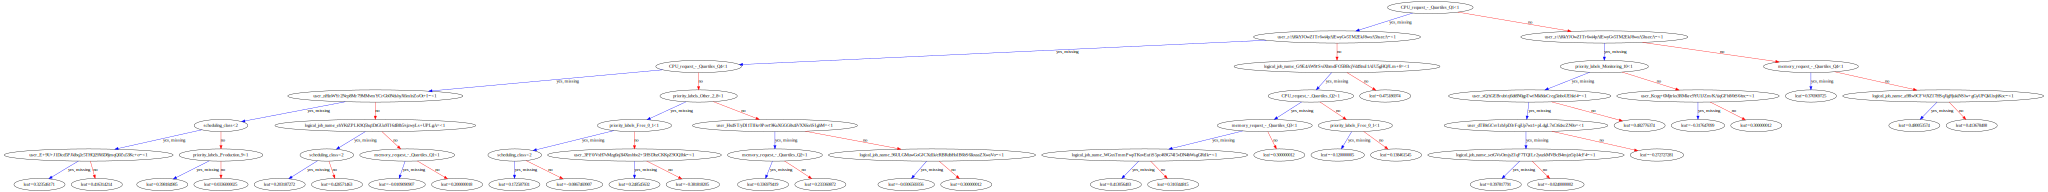

In [91]:
xgb.to_graphviz(model)

In [92]:
scoring = {'acc': 'accuracy',
           'f1_macro': 'f1_macro',
           'f1_weight': 'f1_weighted'}

In [93]:
kfold = KFold(n_splits=10)
model0 = xgb.XGBClassifier(tree_method='gpu_hist', max_depth=6, min_child_weight=1, subsample=0.8879, eta=0.099)
results0 = cross_validate(model0, oneHotDf, (static_metrics['K-Means = 4'] == 0).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:02:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:02:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:04:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:04:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [94]:
print(results0['test_acc'].mean()*100, results0['test_acc'].std()*100) 

80.29664198316246 1.730318892615786


In [95]:
print(results0['test_f1_macro'].mean()*100, results0['test_f1_macro'].std()*100) 

44.7107482291374 0.5881434060981818


In [96]:
print(results0['test_f1_weight'].mean()*100, results0['test_f1_weight'].std()*100) 

71.64032499794872 2.42060489708537


#### K-Means 4 -cl.1

In [97]:
kfold = KFold(n_splits=10)
model1 = xgb.XGBClassifier(tree_method='gpu_hist')
results1 = cross_validate(model, oneHotDf, (static_metrics['K-Means = 4'] == 1).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:06:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:06:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [98]:
print(results1['test_acc'].mean()*100, results1['test_acc'].std()*100) 

99.40096963534822 1.2999793027839874


In [99]:
print(results1['test_f1_macro'].mean()*100, results1['test_f1_macro'].std()*100) 

50.561908821231974 2.203204263288301


In [100]:
print(results1['test_f1_weight'].mean()*100, results1['test_f1_weight'].std()*100) 

99.17481885212858 1.9548425777726586


In [101]:
model1.fit(oneHotDf, (static_metrics['K-Means = 4'] == 1).astype(int).values)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

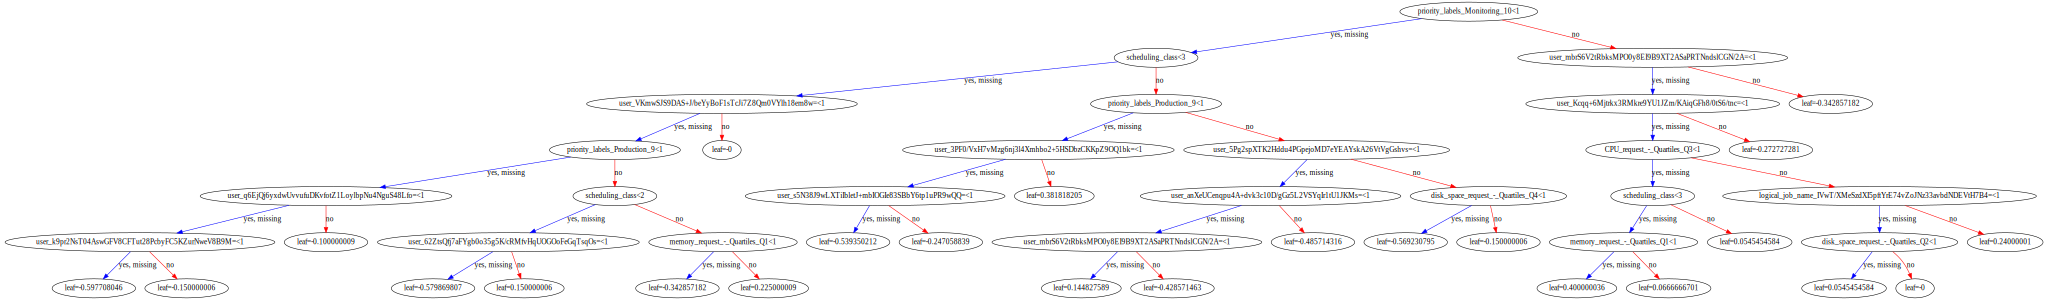

In [102]:
xgb.to_graphviz(model1)

In [105]:
image = xgb.to_graphviz(model1)

#Set a different dpi (work only if format == 'png')
#image.graph_attr = {'dpi':'400'}

#image.render('', format = format)

#### K-Means 4 - cl.2

In [106]:
kfold = KFold(n_splits=10)
model2 = xgb.XGBClassifier(tree_method='gpu_hist')
results2 = cross_validate(model2, oneHotDf, (static_metrics['K-Means = 4'] == 2).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [107]:
print(results2['test_acc'].mean()*100, results2['test_acc'].std()*100) 

98.34445979610555 0.3933326153526172


In [108]:
print(results2['test_f1_macro'].mean()*100, results2['test_f1_macro'].std()*100) 

50.12040750280846 0.7120790429747657


In [109]:
print(results2['test_f1_weight'].mean()*100, results2['test_f1_weight'].std()*100) 

97.54047572945721 0.580225330551923


In [110]:
model2.fit(oneHotDf, (static_metrics['K-Means = 4'] == 2).astype(int).values)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

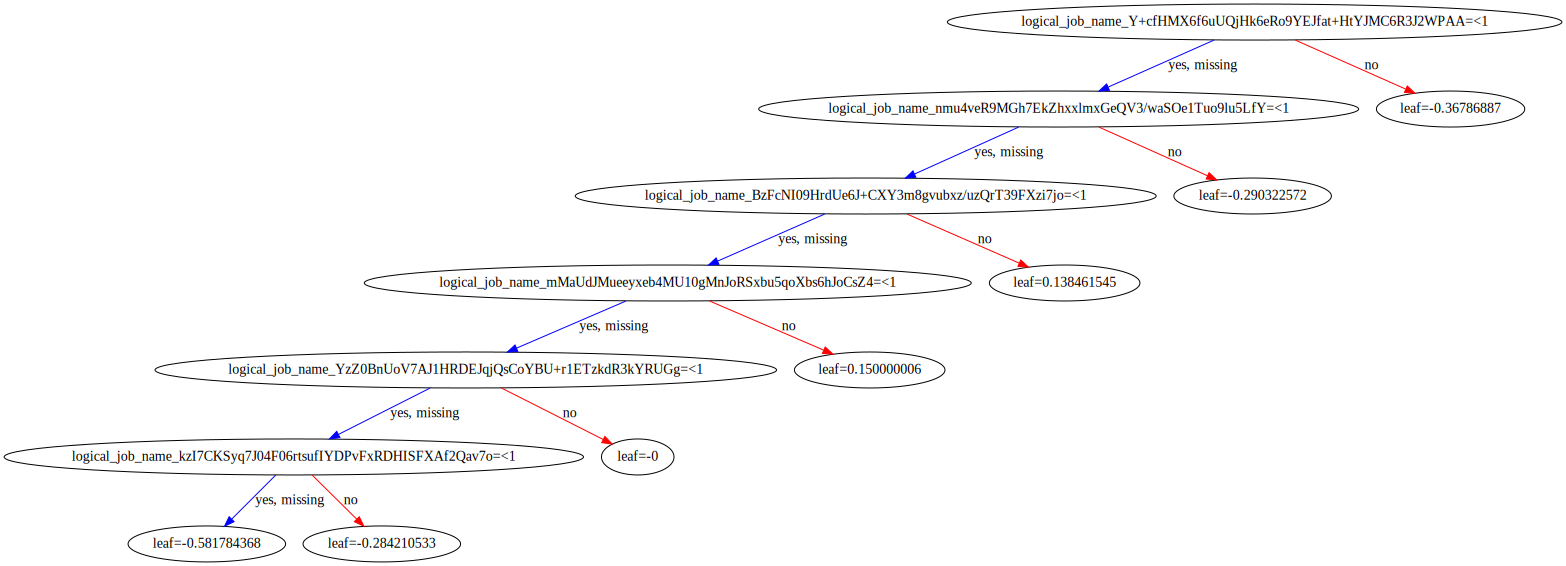

In [111]:
xgb.to_graphviz(model2)

Interpretation of the graph: https://stackoverflow.com/questions/40926340/what-does-the-value-of-leaf-in-the-following-xgboost-model-tree-diagram-means

#### K-Means 4 - cl.3

In [112]:
kfold = KFold(n_splits=10)
model3 = xgb.XGBClassifier(tree_method='gpu_hist')
results3 = cross_validate(model3, oneHotDf, (static_metrics['K-Means = 4'] == 3).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [113]:
print(results3['test_acc'].mean()*100, results3['test_acc'].std()*100) 

82.52657276408306 0.9410264734352454


In [114]:
print(results3['test_f1_macro'].mean()*100, results3['test_f1_macro'].std()*100) 

45.36319663198879 0.4410961417597236


In [115]:
print(results3['test_f1_weight'].mean()*100, results3['test_f1_weight'].std()*100) 

74.68677799572545 1.3144272150136422


In [116]:
model3.fit(oneHotDf, (static_metrics['K-Means = 4'] == 3).astype(int).values)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

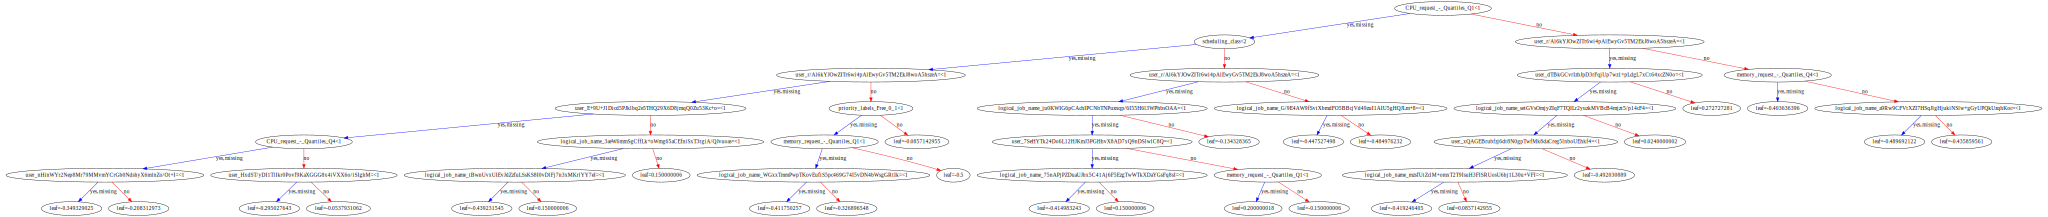

In [117]:
xgb.to_graphviz(model3)

## "Supervised" explanation - reduced metadata

In [118]:
cat_attribs=['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles']
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

In [119]:
oneHotDfReduced = static_metrics[['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles', 'priority','scheduling class']]

In [120]:
encoder = full_pipeline.fit(oneHotDfReduced)
list_of_feature_names = ['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles', 'priority','scheduling class']
x = encoder.get_feature_names_out(list_of_feature_names)
oneHotDfReduced = encoder.transform(oneHotDfReduced)

In [121]:
oneHotDfReduced = pd.DataFrame(oneHotDfReduced, columns=x)

In [122]:
oneHotDfReduced

,cat__different machines restriction_0,cat__different machines restriction_1,cat__disk space request - Quartiles_Q1,cat__disk space request - Quartiles_Q2,cat__disk space request - Quartiles_Q4,cat__memory request - Quartiles_Q1,cat__memory request - Quartiles_Q2,cat__memory request - Quartiles_Q3,cat__memory request - Quartiles_Q4,cat__CPU request - Quartiles_Q1,cat__CPU request - Quartiles_Q2,cat__CPU request - Quartiles_Q3,cat__CPU request - Quartiles_Q4,remainder__priority,remainder__scheduling class
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,3.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,3.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,3.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64928,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
64929,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0
64930,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0
64931,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0


### XGBoost

#### K-Means 4 - cl. 0

In [123]:
model0Red = xgb.XGBClassifier(tree_method='gpu_hist')

In [124]:
model0Red.fit(oneHotDfReduced, (static_metrics['K-Means = 4'] == 0).astype(int).values)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [125]:
model0Red.get_booster().get_score(importance_type='gain')

{'cat__different machines restriction_0': 0.34770137071609497,
 'cat__disk space request - Quartiles_Q1': 0.8792682886123657,
 'cat__disk space request - Quartiles_Q2': 0.8478599786758423,
 'cat__disk space request - Quartiles_Q4': 0.6616125702857971,
 'cat__memory request - Quartiles_Q1': 0.7813892960548401,
 'cat__memory request - Quartiles_Q2': 0.524111270904541,
 'cat__memory request - Quartiles_Q3': 0.9770163893699646,
 'cat__memory request - Quartiles_Q4': 1.1546916961669922,
 'cat__CPU request - Quartiles_Q1': 4.0747480392456055,
 'cat__CPU request - Quartiles_Q2': 0.4241006076335907,
 'cat__CPU request - Quartiles_Q3': 0.5185223817825317,
 'cat__CPU request - Quartiles_Q4': 0.8058767914772034,
 'remainder__priority': 1.554216980934143,
 'remainder__scheduling class': 1.107121467590332}

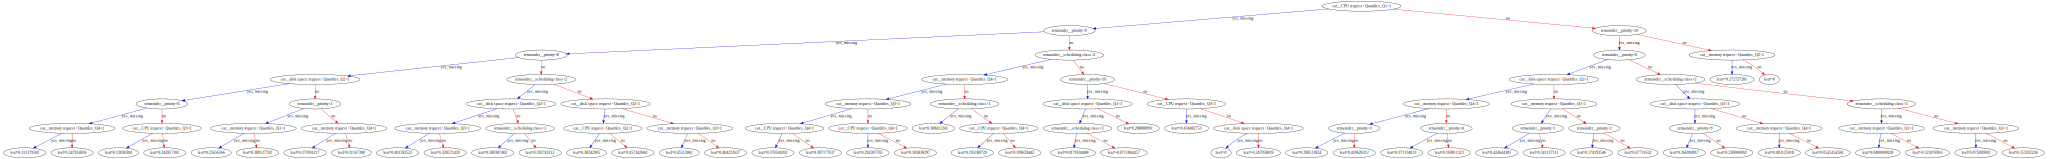

In [126]:
xgb.to_graphviz(model0Red)

In [128]:
scoring = {'acc': 'accuracy',
           'f1_macro': 'f1_macro',
           'f1_weight': 'f1_weighted'}

In [129]:
kfold = KFold(n_splits=10)
#model0Red = xgb.XGBClassifier(tree_method='gpu_hist', max_depth=6, min_child_weight=1, subsample=0.8879, eta=0.099)
results0Red = cross_validate(model0Red, oneHotDfReduced, (static_metrics['K-Means = 4'] == 0).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [130]:
print(results0Red['test_acc'].mean()*100, results0Red['test_acc'].std()*100) 

80.29971558292787 1.6007300488554828


In [131]:
print(results0Red['test_f1_macro'].mean()*100, results0Red['test_f1_macro'].std()*100) 

45.15323917086637 0.6042917883239373


In [132]:
print(results0Red['test_f1_weight'].mean()*100, results0Red['test_f1_weight'].std()*100) 

71.83332181078282 2.0231956153215096


#### K-Means 4 -cl.1

In [133]:
kfold = KFold(n_splits=10)
model1Red = xgb.XGBClassifier(tree_method='gpu_hist')
results1Red = cross_validate(model1Red, oneHotDfReduced, (static_metrics['K-Means = 4'] == 1).astype(int).values, scoring=scoring, cv=kfold)

[13:54:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [134]:
print(results1Red['test_acc'].mean()*100, results1Red['test_acc'].std()*100) 

99.36862877275479 1.2829858258748197


In [135]:
print(results1Red['test_f1_macro'].mean()*100, results1Red['test_f1_macro'].std()*100) 

51.19855761706027 2.7386831630225292


In [136]:
print(results1Red['test_f1_weight'].mean()*100, results1Red['test_f1_weight'].std()*100) 

99.16264823472683 1.9376647919929835


In [137]:
model1Red.fit(oneHotDfReduced, (static_metrics['K-Means = 4'] == 1).astype(int).values)

[13:54:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

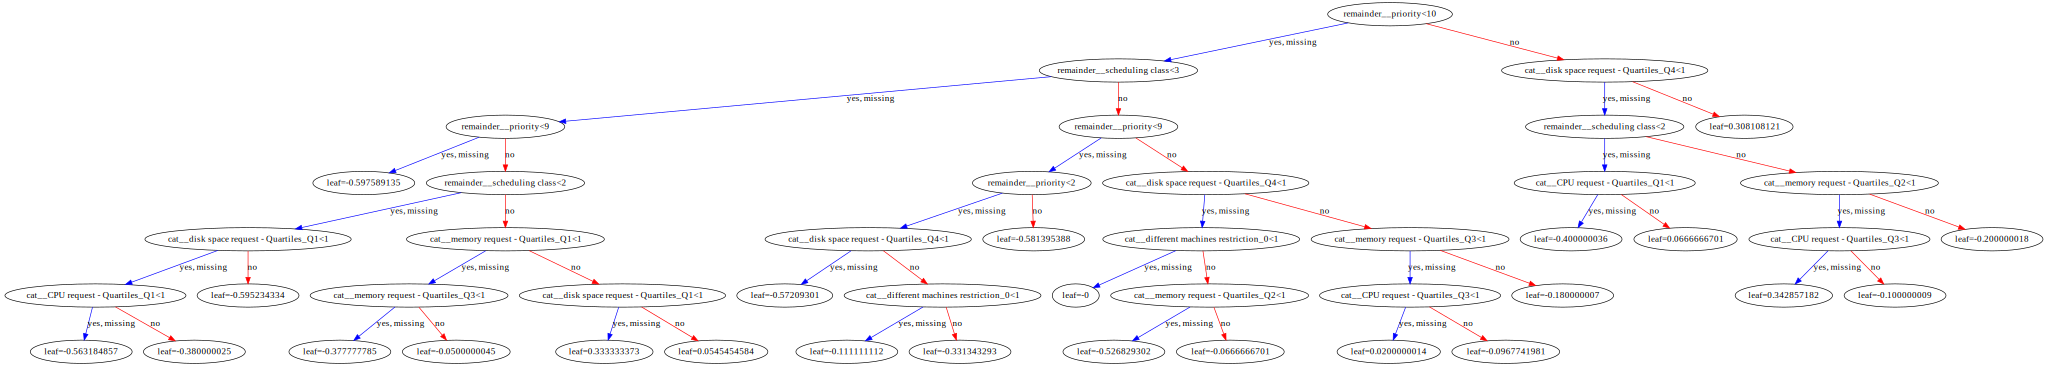

In [138]:
xgb.to_graphviz(model1Red)

#### K-Means 4 - cl.2

In [139]:
kfold = KFold(n_splits=10)
model2Red = xgb.XGBClassifier(tree_method='gpu_hist')
results2Red = cross_validate(model2Red, oneHotDfReduced, (static_metrics['K-Means = 4'] == 2).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [140]:
print(results2Red['test_acc'].mean()*100, results2Red['test_acc'].std()*100) 

98.34291920165523 0.38963643290361144


In [141]:
print(results2Red['test_f1_macro'].mean()*100, results2Red['test_f1_macro'].std()*100) 

49.582074173045854 0.099037774591083


In [142]:
print(results2Red['test_f1_weight'].mean()*100, results2Red['test_f1_weight'].std()*100) 

97.52169005721876 0.5811981053476131


In [143]:
model2Red.fit(oneHotDfReduced, (static_metrics['K-Means = 4'] == 2).astype(int).values)

[13:54:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

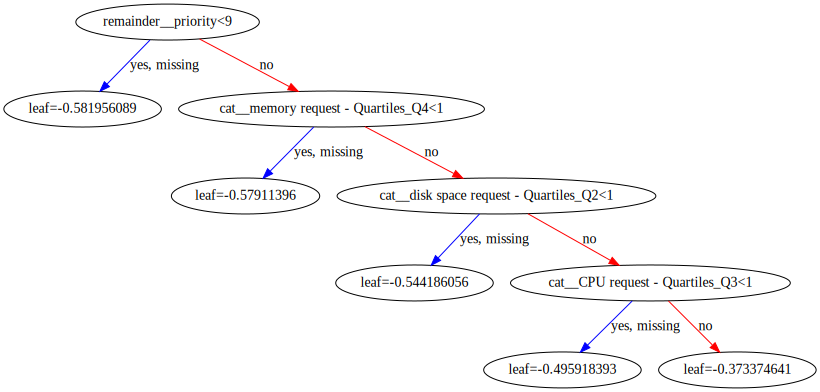

In [144]:
xgb.to_graphviz(model2Red)

Interpretation of the graph: https://stackoverflow.com/questions/40926340/what-does-the-value-of-leaf-in-the-following-xgboost-model-tree-diagram-means

#### K-Means 4 - cl.3

In [145]:
kfold = KFold(n_splits=10,)
model3Red = xgb.XGBClassifier(tree_method='gpu_hist')
results3Red = cross_validate(model3Red, oneHotDfReduced, (static_metrics['K-Means = 4'] == 3).astype(int).values, scoring=scoring, cv=kfold)

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [146]:
print(results3Red['test_acc'].mean()*100, results3Red['test_acc'].std()*100) 

82.43571563719019 0.988794020337936


In [147]:
print(results3Red['test_f1_macro'].mean()*100, results3Red['test_f1_macro'].std()*100) 

45.27596209355676 0.2845653702184277


In [148]:
print(results3Red['test_f1_weight'].mean()*100, results3Red['test_f1_weight'].std()*100) 

74.62087815255525 1.3318226280413448


In [149]:
model3Red.fit(oneHotDfReduced, (static_metrics['K-Means = 4'] == 3).astype(int).values)

[13:54:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

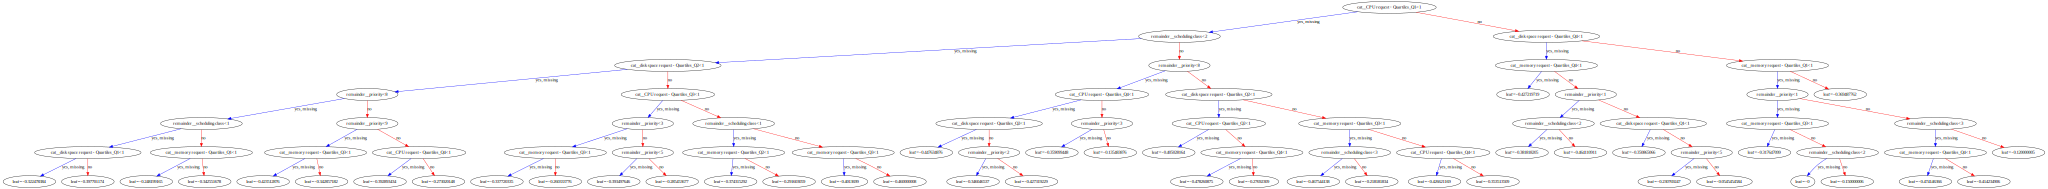

In [150]:
xgb.to_graphviz(model3Red)

## Test set

In [151]:
readings_task_usage_df = pd.read_csv("data/sample_jobs_summary.csv", header=[0,1], index_col=[0])

In [155]:
# Change this with your destination directory
DESTINATION_DIRECTORY = "/data/cloud_data/Google-clusterdata-2011-2/"

In [156]:
data_path = os.path.join(DESTINATION_DIRECTORY, 'clusterdata-2011-2')
schema_path = os.path.join(data_path, 'schema.csv')

In [157]:
df_schema = pd.read_csv(schema_path)

In [162]:
readings_job_events_df = extract_delayed_dask_dataframe(data_path, df_schema, gcd_collection_name="job_events", 
                                                        interval_start=0, interval_end=500)


In [163]:
jobs_metadata = readings_job_events_df[readings_job_events_df["job ID"].isin(readings_task_usage_df.index)].groupby(["job ID", "user", "logical job name"])["scheduling class"].mean().compute().reset_index()


In [ ]:
jobs_metadata

,job ID,user,logical job name,scheduling class
0,1358321947,rNyxTd1B3RnDJBIofzoVksjnmaJEN+hW5W+yRHo2xsM=,MLkuC5OhtyvnNvVp+HTmEy19HlJs69zqeCO4Lcq0u8c=,2.0
1,2715734498,1yz7jCInn0L3rjrXnHi6LG8jjgl73Xluanu0nnNRlIA=,E3CU47f0TYZbFLTxOfUBaZSvWu+9RkwsohOtYSRSXpo=,1.0
2,3600242317,nSLhnjtRmqiT0ytrLIvs8cq2AoFad5WEfGcyNsY+ir0=,L+KdgcshEEhlKnVT1sU6LrLSsUDfORKs6Ey/UswkQ1w=,3.0
3,3996514874,B+humsbEb+EM4XpG1qD7AYgzY8mtpICNPmadBNpFCtQ=,NMKCJpGH1reH4ZbgKhbgstVDHVkYL8x4yUtQBW6Y9io=,2.0
4,4093289082,9bg757+k8xeWFApxOzOS5nnVAHYpBBQ+Pf1mEnsTZsQ=,2tfylK5dgUBPO/k2RsbP5YL4J4eUdleVFKOW1HA8X0g=,3.0
...,...,...,...,...
3260,6486215765,fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,1VyFciXoOQlVF2NCDO0gjgkFKljlC9Hs1pjXN+2VQHk=,2.0
3261,6486230048,fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,ZoHIMIMjYenKtCPq0iy70XUxyF0JDf1HuW6yUzS4dBM=,0.0
3262,6486230146,fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,qScCQcMQhU296kH9oZSt8WJOwmgoO8LjakbqsWAyX1c=,2.0
3263,6486431719,QhKaMUnHYqtG1RJkmo+zqhY1dChfuOZ6oy8jYGDlsic=,ghG9Kj7LnHJzkECBXiyKe/n5Alm+W4bgE4NAxq85l0I=,2.0


In [ ]:
jobs_metadata["scheduling class"].value_counts()

0.0    1225
1.0    1068
2.0     947
3.0      25
Name: scheduling class, dtype: int64

In [166]:
cols_task_events = df_schema[df_schema['file pattern'] == 'task_events/part-?????-of-?????.csv.gz'].content.values
task_events_files = [os.path.join(data_path, 'task_events','part-00'+ str(v).zfill(3)+'-of-00500.csv.gz')
                        for v in range(0, 500)]

dfs_task_events = [delayed(pd.read_csv)(fn, header=None, index_col=False, names=cols_task_events, delimiter=',') for fn in
           task_events_files]
readings_task_events_df = dd.from_delayed(dfs_task_events)
readings_task_events_df = readings_task_events_df[readings_task_events_df['job ID'].isin(readings_task_usage_df.index)].groupby(["job ID"])["priority", "CPU request", "memory request", "disk space request", "different machines restriction"].mean().compute().reset_index()

In [167]:
readings_task_events_df 

,job ID,priority,CPU request,memory request,disk space request,different machines restriction
0,1358321947,9.0,0.031250,0.007950,0.000038,0.000000
1,2715734498,9.0,0.227494,0.038784,0.000199,0.125000
2,3600242317,9.0,0.088080,0.042916,0.000108,1.000000
3,3996514874,9.0,0.066646,0.059060,0.000448,0.290323
4,4093289082,8.0,0.018740,0.007950,0.000077,0.000000
...,...,...,...,...,...,...
3260,6486215765,0.0,0.006248,0.015530,0.000038,0.000000
3261,6486230048,4.0,0.012500,0.001987,0.000038,0.000000
3262,6486230146,0.0,0.006248,0.004662,0.000038,0.000000
3263,6486431719,0.0,0.006248,0.015900,0.000038,0.000000


**TODO**: Do one-hot encoding
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
- https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970


In [168]:
def extract_quartiles(df: pd.DataFrame, column: str):
    q25_val = df[column].quantile(0.25)
    median_val = df[column].median()
    q75_val = df[column].quantile(0.75)
    max_val = df[column].max()
    df[column+" - Q1"] = 0
    df[column+" - Q2"] = 0
    df[column+" - Q3"] = 0
    df[column+" - Q4"] = 0
    df.loc[df[column] <=q25_val, f"{column} - Q1"] = 1
    df.loc[(q25_val < df[column]) & (df[column] <=median_val) , f"{column} - Q2"] = 1
    df.loc[(median_val < df[column]) & (df[column] <=q75_val) , f"{column} - Q3"] = 1
    df.loc[(q75_val < df[column]) & (df[column] <=max_val) , f"{column} - Q4"] = 1
    df.loc[df[column] <=q25_val, f"{column} - Quartiles"] = 'Q1'
    df.loc[(q25_val < df[column]) & (df[column] <=median_val) , f"{column} - Quartiles"] = 'Q2'
    df.loc[(median_val < df[column]) & (df[column] <=q75_val) , f"{column} - Quartiles"] = 'Q3'
    df.loc[(q75_val < df[column]) & (df[column] <=max_val) , f"{column} - Quartiles"] = 'Q4'


In [169]:
def extract_priority(df: pd.DataFrame, column='priority'):
    df.loc[(0 <= df[column]) & (df[column] <= 1), 'priority labels'] = 'Free [0,1]'
    df.loc[(2 <= df[column]) & (df[column] <= 8) , 'priority labels'] = 'Other [2,8]'
    df.loc[(df[column] == 9) , 'priority labels'] = 'Production [9]'
    df.loc[(df[column] == 10), 'priority labels'] = 'Monitoring [10]'
    df.loc[(df[column] == 11), 'priority labels'] = 'Infrastructure [11]'

In [170]:
extract_quartiles(readings_task_events_df, "disk space request")

In [171]:
extract_quartiles(readings_task_events_df, "memory request")

In [172]:
extract_quartiles(readings_task_events_df, "CPU request")

In [173]:
extract_priority(readings_task_events_df)

In [174]:
readings_task_events_df

,job ID,priority,CPU request,memory request,disk space request,different machines restriction,disk space request - Q1,disk space request - Q2,disk space request - Q3,disk space request - Q4,...,memory request - Q2,memory request - Q3,memory request - Q4,memory request - Quartiles,CPU request - Q1,CPU request - Q2,CPU request - Q3,CPU request - Q4,CPU request - Quartiles,priority labels
0,1358321947,9.0,0.031250,0.007950,0.000038,0.000000,0,1,0,0,...,1,0,0,Q2,0,0,1,0,Q3,Production [9]
1,2715734498,9.0,0.227494,0.038784,0.000199,0.125000,0,0,0,1,...,0,0,1,Q4,0,0,0,1,Q4,Production [9]
2,3600242317,9.0,0.088080,0.042916,0.000108,1.000000,0,0,0,1,...,0,0,1,Q4,0,0,0,1,Q4,Production [9]
3,3996514874,9.0,0.066646,0.059060,0.000448,0.290323,0,0,0,1,...,0,0,1,Q4,0,0,0,1,Q4,Production [9]
4,4093289082,8.0,0.018740,0.007950,0.000077,0.000000,0,0,0,1,...,1,0,0,Q2,0,0,1,0,Q3,"Other [2,8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,6486215765,0.0,0.006248,0.015530,0.000038,0.000000,0,1,0,0,...,0,1,0,Q3,1,0,0,0,Q1,"Free [0,1]"
3261,6486230048,4.0,0.012500,0.001987,0.000038,0.000000,0,1,0,0,...,0,0,0,Q1,0,1,0,0,Q2,"Other [2,8]"
3262,6486230146,0.0,0.006248,0.004662,0.000038,0.000000,0,1,0,0,...,0,0,0,Q1,1,0,0,0,Q1,"Free [0,1]"
3263,6486431719,0.0,0.006248,0.015900,0.000038,0.000000,0,1,0,0,...,0,1,0,Q3,1,0,0,0,Q1,"Free [0,1]"


In [175]:
readings_task_events_df_final = readings_task_events_df.drop(columns=['CPU request', 'memory request', 'disk space request'])

In [176]:
static_metrics_test = readings_task_events_df_final.set_index("job ID").join(jobs_metadata.set_index('job ID'))

In [177]:
extract_priority(static_metrics_test)

In [178]:
static_metrics_test

,priority,different machines restriction,disk space request - Q1,disk space request - Q2,disk space request - Q3,disk space request - Q4,disk space request - Quartiles,memory request - Q1,memory request - Q2,memory request - Q3,...,memory request - Quartiles,CPU request - Q1,CPU request - Q2,CPU request - Q3,CPU request - Q4,CPU request - Quartiles,priority labels,user,logical job name,scheduling class
job ID,,,,,,,,,,,,,,,,,,,,,
1358321947,9.0,0.000000,0,1,0,0,Q2,0,1,0,...,Q2,0,0,1,0,Q3,Production [9],rNyxTd1B3RnDJBIofzoVksjnmaJEN+hW5W+yRHo2xsM=,MLkuC5OhtyvnNvVp+HTmEy19HlJs69zqeCO4Lcq0u8c=,2.0
2715734498,9.0,0.125000,0,0,0,1,Q4,0,0,0,...,Q4,0,0,0,1,Q4,Production [9],1yz7jCInn0L3rjrXnHi6LG8jjgl73Xluanu0nnNRlIA=,E3CU47f0TYZbFLTxOfUBaZSvWu+9RkwsohOtYSRSXpo=,1.0
3600242317,9.0,1.000000,0,0,0,1,Q4,0,0,0,...,Q4,0,0,0,1,Q4,Production [9],nSLhnjtRmqiT0ytrLIvs8cq2AoFad5WEfGcyNsY+ir0=,L+KdgcshEEhlKnVT1sU6LrLSsUDfORKs6Ey/UswkQ1w=,3.0
3996514874,9.0,0.290323,0,0,0,1,Q4,0,0,0,...,Q4,0,0,0,1,Q4,Production [9],B+humsbEb+EM4XpG1qD7AYgzY8mtpICNPmadBNpFCtQ=,NMKCJpGH1reH4ZbgKhbgstVDHVkYL8x4yUtQBW6Y9io=,2.0
4093289082,8.0,0.000000,0,0,0,1,Q4,0,1,0,...,Q2,0,0,1,0,Q3,"Other [2,8]",9bg757+k8xeWFApxOzOS5nnVAHYpBBQ+Pf1mEnsTZsQ=,2tfylK5dgUBPO/k2RsbP5YL4J4eUdleVFKOW1HA8X0g=,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6486215765,0.0,0.000000,0,1,0,0,Q2,0,0,1,...,Q3,1,0,0,0,Q1,"Free [0,1]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,1VyFciXoOQlVF2NCDO0gjgkFKljlC9Hs1pjXN+2VQHk=,2.0
6486230048,4.0,0.000000,0,1,0,0,Q2,1,0,0,...,Q1,0,1,0,0,Q2,"Other [2,8]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,ZoHIMIMjYenKtCPq0iy70XUxyF0JDf1HuW6yUzS4dBM=,0.0
6486230146,0.0,0.000000,0,1,0,0,Q2,1,0,0,...,Q1,1,0,0,0,Q1,"Free [0,1]",fJeARInTaIjFrdXGqxap6x2T3TpJB84y9zvFsoGGhjk=,qScCQcMQhU296kH9oZSt8WJOwmgoO8LjakbqsWAyX1c=,2.0


In [179]:
static_metrics_test['priority'] = static_metrics_test['priority'].astype(int)
static_metrics_test['different machines restriction'] = static_metrics_test['different machines restriction'].astype(int)
static_metrics_test['scheduling class'] = static_metrics_test['scheduling class'].astype(int)

In [180]:
static_metrics_test.to_csv('data/static_metrics_test.csv')

In [181]:
static_metrics_test = pd.read_csv('data/static_metrics_test.csv')

In [182]:
oneHotDfTest = static_metrics[['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles', 'priority labels', 'user', 'logical job name', 'scheduling class']]

In [183]:
oneHotDfTest = pd.get_dummies(oneHotDfTest)

In [184]:
oneHotDfTest.columns = [col.replace('[', '').replace(']','').replace(',',' ').replace(' ', '_') for col in oneHotDfTest.columns]

In [193]:
oneHotDfTestReduced = static_metrics_test[['different machines restriction', 'disk space request - Quartiles', 'memory request - Quartiles', 'CPU request - Quartiles', 'priority', 'scheduling class']]

In [196]:
encoded = encoder.transform(oneHotDfTestReduced)

In [199]:
oneHotDfTestReduced = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())

In [200]:
oneHotDfTestReduced.columns = [col.replace('[', '').replace(']','').replace(',',' ').replace(' ', '_') for col in oneHotDfTestReduced.columns]

In [201]:
resTest0 = model0Red.predict_proba(oneHotDfTestReduced)

In [202]:
resTest1 = model1Red.predict_proba(oneHotDfTestReduced)

In [203]:
resTest2 = model2Red.predict_proba(oneHotDfTestReduced)

In [204]:
resTest3 = model3Red.predict_proba(oneHotDfTestReduced)

In [205]:
resTestDict = dict()

In [206]:
resTestDict['cl 0'] = [x[1] for x in resTest0]
resTestDict['cl 1'] = [x[1] for x in resTest1]
resTestDict['cl 2'] = [x[1] for x in resTest2]
resTestDict['cl 3'] = [x[1] for x in resTest3]

In [207]:
resTestDf = pd.DataFrame(resTestDict)

In [208]:
resTestDf

,cl 0,cl 1,cl 2,cl 3
0,0.506495,0.410343,0.025166,0.035419
1,0.573709,0.043017,0.085047,0.299461
2,0.339827,0.494638,0.025139,0.097175
3,0.567494,0.173224,0.004787,0.255836
4,0.538055,0.011465,0.020021,0.022768
...,...,...,...,...
3260,0.844070,0.000300,0.013218,0.142057
3261,0.873945,0.002515,0.003386,0.106983
3262,0.503845,0.058110,0.091945,0.218992
3263,0.844070,0.000300,0.013218,0.142057


In [209]:
resTestDf['final label'] = resTestDf.idxmax(axis=1)

In [210]:
resTestDf['final label'].value_counts()

cl 0    3241
cl 1      15
cl 3       9
Name: final label, dtype: int64

In [211]:
resTestDf['max proba'] = resTestDf.max(axis=1)

In [212]:
resTestDf

,cl 0,cl 1,cl 2,cl 3,final label,max proba
0,0.506495,0.410343,0.025166,0.035419,cl 0,0.506495
1,0.573709,0.043017,0.085047,0.299461,cl 0,0.573709
2,0.339827,0.494638,0.025139,0.097175,cl 1,0.494638
3,0.567494,0.173224,0.004787,0.255836,cl 0,0.567494
4,0.538055,0.011465,0.020021,0.022768,cl 0,0.538055
...,...,...,...,...,...,...
3260,0.844070,0.000300,0.013218,0.142057,cl 0,0.844070
3261,0.873945,0.002515,0.003386,0.106983,cl 0,0.873945
3262,0.503845,0.058110,0.091945,0.218992,cl 0,0.503845
3263,0.844070,0.000300,0.013218,0.142057,cl 0,0.844070


In [213]:
resTestDf['final label'].value_counts()

cl 0    3241
cl 1      15
cl 3       9
Name: final label, dtype: int64

Text(0.5, 1.0, 'CDF prediction probability')

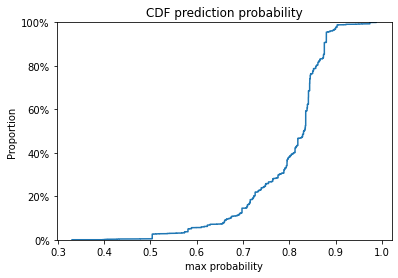

In [214]:


ecdf_summary = sns.ecdfplot(x='max proba', data=resTestDf, complementary=False) 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("max probability")
plt.title("CDF prediction probability")

## Watermark

In [215]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2022-01-26T16:31:51.250528+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.18.0-193.28.1.el8_2.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 80
Architecture: 64bit

xgboost   : 1.5.2
dask      : 2021.10.0
matplotlib: 3.4.3
numpy     : 1.21.2
seaborn   : 0.11.0
pandas    : 1.3.5

